In [1]:
import os
import pickle

from typing import Any, Dict, Tuple
import pandas as pd
import geopandas as gpd
import json
from ast import literal_eval as make_tuple

from utils.error_metrics import MulticlassErrorMetrics, DatasetCategory

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

import contextily
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def get_dataset_with_dependend_variabels(
    df_set: pd.DataFrame, df_dependent: pd.DataFrame
) -> pd.DataFrame:
    df = df_set[
        ["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]
    ].copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    df_dependent["Date"] = pd.to_datetime(df_dependent["Date"]).dt.date
    df = df.merge(df_dependent, on=["Date", "Area"])
    return df


def xy_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return (
        df.drop(
            columns=["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]
        ),
        df["mapped_hazard_forecast"],
    )


def fit_and_compute_errors(
    errs: MulticlassErrorMetrics,
    independent_variables_and_sets: Tuple[str, Dict[DatasetCategory, pd.DataFrame]],
    model_name_and_pipeline: Tuple[str, Pipeline],
):
    independent_variables = independent_variables_and_sets[0]
    sets = independent_variables_and_sets[1]
    model_name = model_name_and_pipeline[0]
    pipe = model_name_and_pipeline[1]

    training_set = sets[DatasetCategory.TRAINING]
    x, y = xy_split(training_set)
    pipe.fit(x, y)

    for ds_type, ds in sets.items():
        x, _ = xy_split(ds)
        y_pred = pipe.predict(x)
        errs.compute_errors(model_name, independent_variables, ds_type, y_pred)


def params_to_file(file_name: str, params: Dict[str, Any]) -> None:
    with open(f"../data/aux/params/{file_name.replace(".*","")}.json", "w") as f:
        json.dump(params, f)


def params_from_file(file_name: str) -> Dict[str, Any]:
    file_name = f"../data/aux/params/{file_name.replace(".*","")}.json"
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"The file {file_name} does not exist.")
    with open(file_name, "r") as f:
        d = json.load(f)
        hidden_layer_sizes = d.get("hidden_layer_sizes", None)
        if not hidden_layer_sizes is None:
            d["hidden_layer_sizes"] = make_tuple(hidden_layer_sizes)
        return d

In [2]:
df_train = pd.read_csv("../data/processed/SAIS_train.csv", index_col=0)
df_train["Date"] = pd.to_datetime(df_train["Date"]).dt.date
df_test = pd.read_csv("../data/processed/SAIS_test.csv", index_col=0)
df_test["Date"] = pd.to_datetime(df_test["Date"]).dt.date

rerun=False
# no point storing the combined frame
if rerun:
    df_combined = pd.concat([df_train, df_test])
    df_grouped = df_combined.groupby("Date").size().reset_index(name="count")
    randomly_selected_dates = df_grouped[df_grouped["count"] == 6]["Date"].sample(5, random_state=1).tolist()
    with open("../data/aux/randomly_selected_dates.csv", "w") as f:
        pd.Series(randomly_selected_dates).to_csv(f, index=False, header=["Date"])

randomly_selected_dates = pd.read_csv("../data/aux/randomly_selected_dates.csv", header=0)
randomly_selected_dates["Date"] = pd.to_datetime(randomly_selected_dates["Date"]).dt.date
randomly_selected_dates = randomly_selected_dates['Date'].unique().tolist()

df_entries_to_move = df_train[df_train["Date"].isin(randomly_selected_dates)]
df_train = df_train[~df_train["Date"].isin(randomly_selected_dates)]
df_test = pd.concat([df_test, df_entries_to_move])

df_tab = pd.read_csv("../data/processed/SAIS_tabularised.csv", index_col=0)

df_train_tab = df_tab.loc[df_train.index]
df_test_tab = df_tab.loc[df_test.index]

df_weather_data_daily_tab = pd.read_csv(
    "../data/proprietary/weather/visual_crossing/weather_observed_days_tabularised.csv"
)
df_weather_data_48h_then_daily_tab = pd.read_csv(
    "../data/proprietary/weather/visual_crossing/weather_observed_tabularised_48_hours_then_days.csv"
)

snowprofiles = (
    "snow profiles",
    {
        DatasetCategory.TRAINING: df_train,
        DatasetCategory.TEST: df_test,
    },
)

snowprofiles_whole_season = (
    "snow profiles across season",
    {
        DatasetCategory.TRAINING: df_train_tab,
        DatasetCategory.TEST: df_test_tab,
    },
)

weather_daily_whole_season = (
    "weather daily data across season",
    {
        DatasetCategory.TRAINING: get_dataset_with_dependend_variabels(
            df_train, df_weather_data_daily_tab
        ),
        DatasetCategory.TEST: get_dataset_with_dependend_variabels(
            df_test, df_weather_data_daily_tab
        ),
    },
)

weather_48h_then_daily_season = (
    "weather 48h hourly then daily data across season",
    {
        DatasetCategory.TRAINING: get_dataset_with_dependend_variabels(
            df_train, df_weather_data_48h_then_daily_tab
        ),
        DatasetCategory.TEST: get_dataset_with_dependend_variabels(
            df_test, df_weather_data_48h_then_daily_tab
        ),
    },
)

errs_summary = MulticlassErrorMetrics(
    dataset_name="sais",
    classes=sorted(df_train["mapped_hazard_forecast"].unique()),
    y_true_train=df_train["mapped_hazard_forecast"],
    y_true_dev=None,
    y_true_test=df_test["mapped_hazard_forecast"],
)


In [3]:
most_frequent_value = df_train["mapped_hazard_forecast"].value_counts().index[0]

run = lambda model, data: fit_and_compute_errors(
    errs=errs_summary,
    independent_variables_and_sets=data,
    model_name_and_pipeline=model,
)

model_name_const = "const "
errs_summary.compute_errors_all_sets(
    model_name_const,
    None,
    most_frequent_value,
    None,
    most_frequent_value,
)
model_name_obs = "obs.  "
errs_summary.compute_errors_all_sets(
    model_name_obs,
    None,
    df_train["mapped_hazard_observed"],
    None,
    df_test["mapped_hazard_observed"],
)

scaler = StandardScaler()

softmax_snow = (
    "SM(S)",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", LogisticRegression(random_state=1)),
        ]
    ),
)

softmax = (
    "SM    ",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", LogisticRegression(random_state=1)),
        ]
    ),
)

softmax_tuned = (
    "SM(T)",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", LogisticRegression(random_state=1).set_params(
                    **params_from_file("softmax_tuned"))),
        ]
    ),
)

random_forest = (
    "RF    ",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", RandomForestClassifier(random_state=1)),
        ]
    ),
)

random_forest_tuned = (
    "RF(T) ",
    Pipeline(
        [
            ("scaler", scaler),
            (
                "model",
                RandomForestClassifier(random_state=1).set_params(
                    **params_from_file("random_forest_tuned")
                ),
            ),
        ]
    ),
)
random_forest_tuned[1]["model"].set_params(**{"warm_start": False})

mlp = (
    "MLP   ",
    Pipeline(
        [
            ("scaler", scaler),
            ("model", MLPClassifier(random_state=1, early_stopping=True)),
        ]
    ),
)


mlp_tuned = (
    "MLP(T)",
    Pipeline(
        [
            ("scaler", scaler),
            (
                "model",
                MLPClassifier(random_state=1, early_stopping=True).set_params(
                    **params_from_file("mlp_tuned")
                ),
            ),
        ]
    ),
)

In [4]:
rerun = True

#long-running
if rerun:
    run(softmax_snow, snowprofiles)

    # run(softmax, snowprofiles_whole_season)

    # run(softmax, weather_daily_whole_season)

    run(softmax, weather_48h_then_daily_season)

    run(softmax_tuned, weather_48h_then_daily_season)

    run(random_forest, weather_48h_then_daily_season)

    run(mlp, weather_48h_then_daily_season)

    run(random_forest_tuned, weather_48h_then_daily_season)

    run(mlp_tuned, weather_48h_then_daily_season)
    with open("../data/aux/errs_summary.pkl", "wb") as f:
        pickle.dump(errs_summary, f)
else:
    with open("../data/aux/errs_summary.pkl", 'rb') as f:
        errs_summary = pickle.load(f)

/Users/witold/Repos/witgaw/avalanche-danger-level-forecast/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/witold/Repos/witgaw/avalanche-danger-level-forecast/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [5]:
errs_summary.save_assets(table_transpose=True, table_model_name_only=True, table_float_format = "{:0.2f}", table_caption_additional=". \\\\ SM = softmax, RF = Random forest, MLP = Multi-layer perceptron, S = snow profiles, T = tuned")

errs_summary.get_error_table_for_set(DatasetCategory.TEST)

,MSE,average error,accuracy,precision:,1,2,3,4,,prec. (macro),...,,recall (macro),$F_1$:,1,2,3,4,,$F_1$ (macro),confusion matrix
"const , None",1.629779,-0.895372,0.328471,,0.0,0.0,0.33,0.0,,0.082118,...,,0.25,,0.0,0.0,0.49,0.0,,0.123627,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [..."
"obs. , None",0.298793,0.146881,0.759557,,0.76,0.69,0.84,0.67,,0.739099,...,,0.686623,,0.84,0.67,0.78,0.52,,0.702914,"[[0.9275590551181102, 0.07244094488188976, 0.0..."
"SM(S), snow profiles",0.520624,0.06992,0.611167,,0.68,0.48,0.62,0.4,,0.545251,...,,0.490495,,0.74,0.4,0.68,0.11,,0.481779,"[[0.8015748031496063, 0.15748031496062992, 0.0..."
"SM , weather 48h hourly then daily data across season",0.559356,0.009054,0.60161,,0.71,0.48,0.63,0.44,,0.564661,...,,0.557224,,0.71,0.49,0.63,0.42,,0.560737,"[[0.710236220472441, 0.2173228346456693, 0.066..."
"SM(T), weather 48h hourly then daily data across season",0.580986,-0.073944,0.610664,,0.74,0.52,0.65,0.32,,0.559133,...,,0.613806,,0.73,0.51,0.63,0.43,,0.573804,"[[0.7244094488188977, 0.1968503937007874, 0.06..."
"RF , weather 48h hourly then daily data across season",0.38833,0.032193,0.68662,,0.77,0.6,0.66,0.82,,0.714061,...,,0.578077,,0.8,0.55,0.72,0.31,,0.594428,"[[0.8251968503937008, 0.13228346456692913, 0.0..."
"MLP , weather 48h hourly then daily data across season",0.433602,0.024145,0.673541,,0.76,0.58,0.68,0.61,,0.654015,...,,0.610977,,0.78,0.55,0.7,0.47,,0.625912,"[[0.7952755905511811, 0.16062992125984252, 0.0..."
"RF(T) , weather 48h hourly then daily data across season",0.44668,0.035211,0.671026,,0.75,0.6,0.64,0.85,,0.711251,...,,0.56383,,0.78,0.55,0.7,0.3,,0.580262,"[[0.8062992125984252, 0.12440944881889764, 0.0..."
"MLP(T), weather 48h hourly then daily data across season",0.400905,0.03672,0.67505,,0.78,0.55,0.7,0.64,,0.667566,...,,0.606321,,0.78,0.57,0.7,0.46,,0.62675,"[[0.7732283464566929, 0.1921259842519685, 0.03..."


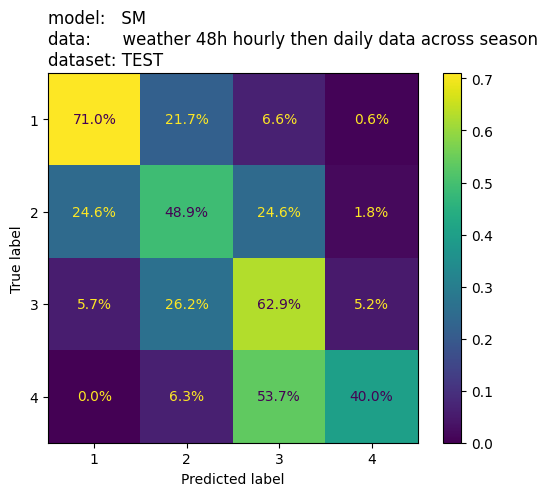

In [6]:
errs_summary.show_confusion_matrix(
    model_name=softmax[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)

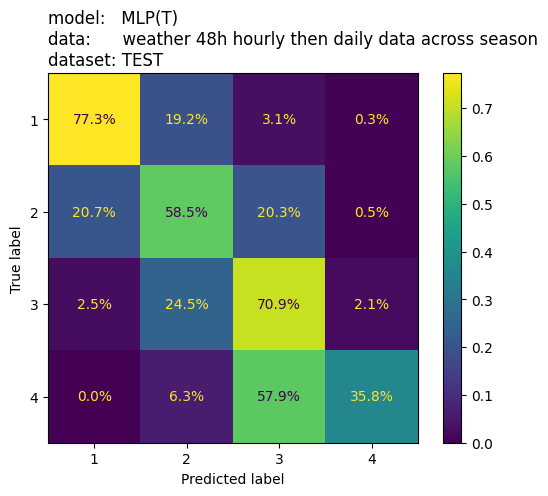

In [7]:
errs_summary.show_confusion_matrix(
    model_name=mlp_tuned[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)

## Hyperparameter tuning

In [8]:
rerun_softmax = False
rerun_random_forest = False
rerun_mlp = False

# long running
if rerun_softmax:
    grid = {
        "model__warm_start": [True],
        "model__penalty": ["l1", "l2", "elasticnet", None],
        "model__tol": [1e-2, 1e-4, 1e-6],
        "model__C": [1e-3, 1e-2, 1e-1, 1],
        "model__fit_intercept": [False, True],
        "model__solver": ["lbfgs", "newton-cg", "sag", "saga"],
        "model__class_weight": [
            "balanced",
            "balanced_subsample",
            {1: 0.1, 2: 0.3, 3: 0.1, 4: 0.5},
            {1: 0.01, 2: 0.45, 3: 0.09, 4: 0.45},
        ],
    }
    random_search_softmax = RandomizedSearchCV(
        estimator=softmax[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
        verbose=1
    )

    run(
        ("Softmax (tuned)", random_search_softmax),
        weather_48h_then_daily_season,
    )
    params_to_file(
        "softmax_tuned", random_search_softmax.best_estimator_["model"].get_params()
    )

# long running
if rerun_random_forest:
    # Followed approach in: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    grid = {
        "model__n_estimators": [100,200],
        "model__criterion": ["gini", "entropy", "log_loss"],
        "model__max_features": [None, "sqrt", "log2"],
        "model__max_depth": [None, 10, 50],
        "model__class_weight": [
            "balanced",
            {1: 0.01, 2: 0.45, 3: 0.09, 4: 0.45},
        ],
    }
    random_search_random_forrest = RandomizedSearchCV(
        estimator=random_forest[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
        verbose=1
    )

    run(
        ("Random forrest (tuned)", random_search_random_forrest),
        weather_48h_then_daily_season,
    )
    params_to_file(
        "random_forest_tuned",
        random_search_random_forrest.best_estimator_["model"].get_params(),
    )


# long running
if rerun_mlp:

    grid = {
        "model__hidden_layer_sizes": [
            (100,),
            (1000,),
            (100, 300, 100),
            (10, 30, 10),
            (20,),
        ],
        "model__activation": ["relu", "logistic", "tanh"],
        "model__solver": ["sgd", "adam"],
        "model__alpha": [0.0001, 0.001, 0.01],
        "model__learning_rate": ["constant", "invscaling", "adaptive"],
        "model__momentum": [0.1, 0.5, 0.9],
    }

    random_search_mlp = RandomizedSearchCV(
        estimator=mlp[1],
        n_jobs=-1,
        cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
        param_distributions=grid,
        scoring="f1_macro",
        n_iter=20,
        verbose=1,
    )

    run(("MLP (tuned)", random_search_mlp), weather_48h_then_daily_season)
    params_to_file("mlp_tuned", random_search_mlp.best_estimator_["model"].get_params())

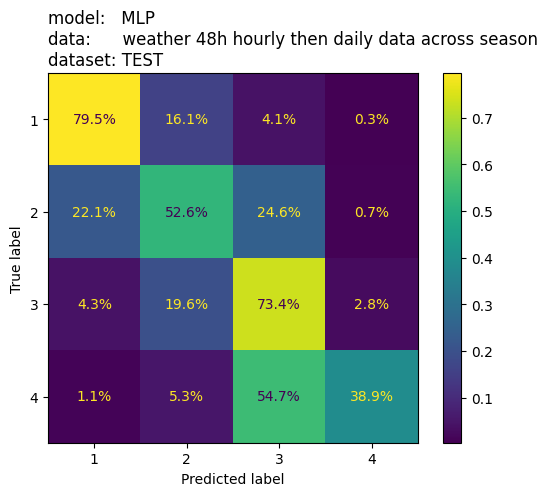

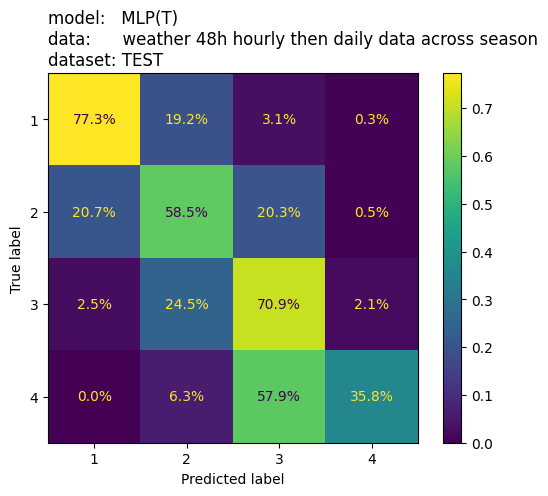

In [54]:
errs_summary.show_confusion_matrix(
    model_name=mlp[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)
errs_summary.show_confusion_matrix(
    model_name=mlp_tuned[0],
    independent_variables=weather_48h_then_daily_season[0],
    set_cat=DatasetCategory.TEST,
)

## Model prediction visualisation

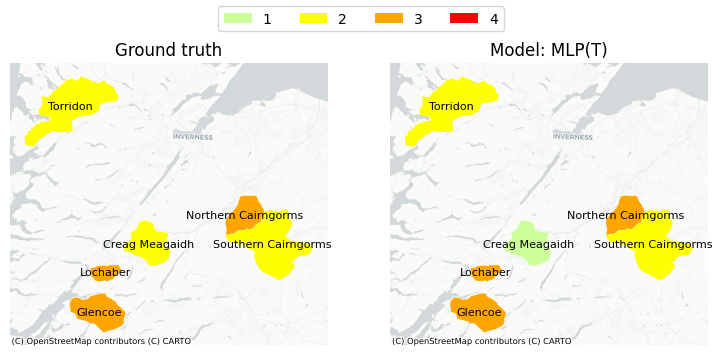

In [44]:
def plot_forecasts(
    polygon_areas: gpd.GeoDataFrame, 
    forecast_actual: Dict[str, int], 
    forecast_model: Dict[str, int], 
    model_name: str,
    show_plot:bool = True,
    save_plot:bool = False,
    colours: Dict[int, str] = {1: '#CCFF99', 2: '#FFFF00', 3: '#FFA500', 4: '#FF0000'}
) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    
    for ax, forecast, title in zip(axs, [forecast_actual, forecast_model], ["Ground truth", f"Model: {model_name}"]):
        pmarks = []
        for label, data in polygon_areas.groupby("name"):
            c = colours[forecast.get(label, 1)]
            data.plot(ax=ax, color=c)
            for x, y, label in zip(data.geometry.centroid.x, data.geometry.centroid.y, data["name"]):
                ax.text(x, y, label, fontsize=8, ha='center', va='center')
            pmarks.append(Patch(facecolor=c, label=forecast.get(label, 1)))

        attribution_size = 6 if save_plot else 8
        contextily.add_basemap(ax, crs=polygon_areas.crs.to_string(), interpolation='sinc', source=contextily.providers.CartoDB.Positron, attribution_size=attribution_size)
        ax.set_title(f"{title}")
        ax.axis("off")
    
    legend_elements = [Patch(facecolor=col, label=f"{key}") for key, col in colours.items()]
    fig.legend(handles=legend_elements, loc='upper center', ncol=len(colours))
    
    if save_plot:
        plt.savefig(f"../tex/assets/figures/forecast_plot_{model_name}_{date}.png", dpi=300, bbox_inches='tight')
    if show_plot:
        plt.show()
    return 

polygons_path = "../data/aux/SAIS_areaPolygons.geojson"

gdf_areas = gpd.read_file(polygons_path).to_crs(epsg=27700)
forecast = {"Creag Meagaidh": 1, "Glencoe": 2, "Lochaber": 2, "Northern Cairngorms": 2,	"Southern Cairngorms": 3, "Torridon": 4}

date = randomly_selected_dates[3]

def plot_given_date(date, model, show_plot=True, save_plot=False):
    forecast_actual = df_test[df_test["Date"] == date].set_index("Area")["mapped_hazard_forecast"].to_dict()

    df_test_48h_then_daily = weather_48h_then_daily_season[1][DatasetCategory.TEST]
    test_data_for_date = df_test_48h_then_daily[df_test_48h_then_daily["Date"] == date]

    x_test, _ = xy_split(test_data_for_date)
    forecast_model = dict(zip(test_data_for_date["Area"],model[1].predict(x_test)))

    plot_forecasts(polygon_areas=gdf_areas, forecast_actual=forecast_actual, forecast_model=forecast_model, model_name=model[0], show_plot=show_plot, save_plot=save_plot)

plot_given_date(date, mlp_tuned, save_plot=True)

In [48]:
import ipywidgets as widgets
from IPython.display import display

def generate_simple_ui(dates, model):

    index_text = widgets.IntText(value=0, description='Index:', min=0, max=len(dates)-1)
    left_button = widgets.Button(description='←', layout=widgets.Layout(width='40px'))
    right_button = widgets.Button(description='→', layout=widgets.Layout(width='40px'))
    output = widgets.Output()

    def on_left_button_clicked(b):
        index_text.value = max(0, index_text.value - 1)

    def on_right_button_clicked(b):
        index_text.value = min(len(dates) - 1, index_text.value + 1)

    left_button.on_click(on_left_button_clicked)
    right_button.on_click(on_right_button_clicked)

    def update_output(index):
        with output:
            date = randomly_selected_dates[index]
            plot_given_date(date, model, show_plot=False)
            output.clear_output()
            print(f"{date}")
            plt.show()

    widgets.interactive(update_output, index=index_text)

    nav_box = widgets.HBox([left_button, index_text, right_button])

    display(nav_box, output)

generate_simple_ui(randomly_selected_dates, mlp_tuned)

Output()